# Variational Quantum Eigen Solver (VQE) Tutorial

This tutorial is intended for new students working on quantum computing projects with Dr. Michael McGuigan. It gives a brief overview of the theory behind the variational method and gives an in-depth guide to running your first VQE program using IBM's QISKit python library. We will do two examples: The 1-D Harmonic Oscillator as well as the 1-D Anharmonic Oscillator

# The Variational Method

## Claim:
The Variational method guarentees to set an upper bound for the ground state energy ($E_{gs}$) of a system described by the Hamiltonian H


\begin{equation}E_{gs} \leqslant \langle\psi|H|\psi\rangle \equiv \langle H\rangle\end{equation}

The variational method is so powerful because it can give a somewhat accurate idea of the ground state energy of a system by simply guessing a trial wave fucntion and finding $\langle H\rangle$. 

## 1-D Harmonic Oscillator Example 
##### From example 7.1 on pgs. 294-295 of D.J. Griffiths' Introduction to Quantum Mechanics
Suppose we start with the following potential $V(x)$:
\begin{equation}
V(x) = \frac{1}{2}m\omega^{2}x^{2}
\end{equation}

With this, the Hamiltonian is written:

\begin{equation}
H = -\frac{\hbar^{2}}{2m}\frac{d^{2}}{dx^{2}} + \frac{1}{2}m\omega^{2}x^{2}
\end{equation}

To find an upper bound for $E_{gs}$ we start by choosing a trial wave function. We'll try:

\begin{equation}\psi(x) = Ae^{-bx^{2}}\end{equation}
where b is a constant and A is the normalization constant.

Now we find the expectation value of the Hamiltonian

\begin{equation}\langle{H}\rangle{} = \langle{T}\rangle + \langle{V}\rangle\end{equation}

where the expectation of the kinetic energy is

\begin{equation}\langle{T}\rangle = -\frac{\hbar^{2}}{2m}|A^{2}| \int_{-\infty}^{\infty} e^{-bx^{2}} \frac{d^{2}}{dx^{2}} e^{-bx^{2}}dx = \frac{\hbar^{2}b}{2m}\end{equation}

and the expectation of the potential energy is

\begin{equation}\langle{V}\rangle = \frac{1}{2}m\omega^{2}x^{2}|A^{2}| \int_{-\infty}^{\infty} e^{-2bx^{2}}dx = \frac{m\omega^{2}}{8b}\end{equation}

Therefore:

\begin{equation}\langle H\rangle = \frac{\hbar^{2}b}{2m} + \frac{m\omega^{2}}{8b}\end{equation}

The above relation exceeds $E_{gs}$ for any b, therefore, to get the greatest lower bound we need to minimize $\langle H\rangle$

\begin{equation}\frac{d}{db}\langle H\rangle = \frac{\hbar^{2}}{2m} - \frac{m\omega^{2}}{8b^{2}} = 0 \implies b = \frac{m\omega}{2\hbar}\end{equation}

After pluggin this back into $\langle H\rangle$ we get the familiar result:

\begin{equation}\langle H\rangle_{min} = \frac{1}{2}\hbar\omega\end{equation}

# Dependencies

Note: if all of the versions don't match with your own you may run into errors while running VQE

In [6]:
# Importing useful packages
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt

# Importing QISKit
from qiskit import Aer, execute, BasicAer
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.aqua.components.initial_states import Custom
from qiskit.aqua.components.variational_forms import RY, RYRZ
from qiskit.aqua.operators.op_converter import to_weighted_pauli_operator
from qiskit.aqua.components.optimizers import COBYLA, SPSA, L_BFGS_B, SLSQP
from qiskit.aqua.operators import (TPBGroupedWeightedPauliOperator, WeightedPauliOperator, MatrixOperator)

import qiskit.tools.jupyter 
%qiskit_version_table

# Running VQE

In [17]:
def run_VQE(**kwargs):
    """Runs the Variational Quantum Eigensolver (VQE)
    
    Args:
        file_path (str): path to txt file containing Hamiltonian
        simulator (str): [statevector_simulator, qasm_simulator] The type of simulator 
            you wish to use (statevector is noiseless, while qasm contains a noise model)
        
    Returns:
        return_dict (dict): Dictionary with the following Keys:
            file_name (str): Name of file used for simulation
            
            result_df (DataFrame): Pandas DataFrame containing the 
                convergence count (df index), convergence_vals, and percent_error
                
            reference_val (float): GS Energy found using the Exact Eigen Solver
            
            algos (QISKit VQE Object): Object returned by the VQE algorithm class
            
            algo_results (dict): Results from VQE run (one algorithim result dict
                for each optimizer) 
    """
    file_path = kwargs['file_path']
    init_state_name = kwargs['init_state_name']
    vf_name = kwargs['vf_name']
    depth = kwargs['depth']
    shots = kwargs['shots']
    simulator = kwargs['simulator']
    
    # Loading matrix representation of Hamiltonian txt file
    H = np.loadtxt(file_path)
    
    # Converting Hamiltonian to Matrix Operator
    qubit_op = MatrixOperator(matrix=H)
    
    # Converting to Pauli Operator
    qubit_op = to_weighted_pauli_operator(qubit_op)
    start = time.time()
    
    num_qubits = qubit_op.num_qubits
    num_paulis = len(qubit_op.paulis)
    num_qubits = qubit_op.num_qubits
    
    print(f"""{num_paulis} Pauli factors \n{round(time.time()-start)} s to process""")
    
    # Solving system exactly for reference value
    ee = ExactEigensolver(qubit_op)
    result = ee.run()
    ref = result['energy']

    # Setting initial state, variational form, and backend
    init_state = init_state_name(num_qubits)
    var_form = vf_name(num_qubits,
                      depth=depth,
                      entanglement='linear',
                      initial_state=init_state)
    
    backend = BasicAer.get_backend(simulator)

    # Don't use SPSA if using a noiseless simulator
    if simulator == 'statevector_simulator':
        optimizers = [COBYLA, L_BFGS_B, SLSQP]  
    else:
        optimizers = [SPSA]
    
    # Initializing empty lists & dicts for storage
    dfs = []
    algos = {}
    algo_results = {}
    for optimizer in optimizers:
        # For reproducibility
        aqua_globals.random_seed = 250
        print(f'\rOptimizer: {optimizer.__name__}          ', end='')

        counts = []
        values = []
        params = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
        
        # Running VQE 
        algo = VQE(qubit_op, var_form, optimizer(), callback=store_intermediate_result)
        quantum_instance = QuantumInstance(backend=backend, shots=shots)  
        algo_result = algo.run(quantum_instance)
        
        # Appending each optimizer data frame to one list
        dfs.append(pd.DataFrame(values, columns=['convergence_vals'], index=counts))
        algos[optimizer.__name__] = algo
        algo_results[optimizer.__name__] = algo_result

    print('\rOptimization complete')
    
    # Formatting return data frame
    results = pd.concat([df for df in dfs], keys=[optimizer.__name__ for optimizer in optimizers])
    results['energy_diff'] = results['convergence_vals'].apply(lambda x: abs(x - ref))
    results['percent_error'] = results['convergence_vals'].apply(lambda x: (abs(x - ref)/ref)*100)
    
    return_dict = {}
    return_dict['file_name'] = file_path
    return_dict['result_df'] = results
    return_dict['reference_val'] = ref
    return_dict['algos'] = algos
    return_dict['algo_results'] = algo_results
    
    return return_dict

def print_table(**result_dict):
    """Prints results of VQE simulation for each optimizer
    
    Args:
        result_dict (dict): Dictionary returned from run_VQE function
        
    Returns: None
    """
    
    algo_results = result_dict['algo_results']
    ref_val = result_dict['reference_val']
    file_name = result_dict['file_name']
    fn = file_name.split('/')[-1].replace(".txt", "")
    
    print(f'\nHamiltonian: {fn}')
    print(f'Reference Value: {ref_val}')
    
    optimizers = algo_results.keys()
    vals = []
    for opt in optimizers:
        vals.append([opt, 
                     algo_results[opt]['energy'], 
                     abs((algo_results[opt]['energy'] - ref_val)/ref_val)*100])
    
    sorted_vals = sorted(vals, key=lambda x: x[2])
    print(tabulate(sorted_vals, 
                   tablefmt="fancy_grid", 
                   headers=['Optimizer', 'VQE Energy', '% Error'], 
                   numalign="right"))

# Visualizing Results

In [8]:
def visualize_results(**result_dict):
    """Graphs optimizer energy convergence and convergence of most effective
        optimizer.
        
    Args:
        result_dict (dict): Dictionary returned from run_VQE function
        
    Returns: None
    """ 
    result_df = result_dict['result_df']
    algo_results = result_dict['algo_results']
    ref_val = result_dict['reference_val']
    
    # Optimizer Convergence
    plt.figure(figsize=(10, 5))
    for opt in result_df.index.unique(0):
        result_df['energy_diff'][opt].plot(logy=True, label=opt)
        
    plt.title('Optimizer Energy Convergence')
    plt.xlabel('Eval count')
    plt.ylabel('Energy difference from solution reference value')
    plt.legend()
    sns.despine()
    plt.show();
    
    # Most effective optimizer
    most_eff = sorted([(opt, 
                        result_df['percent_error'][opt].iloc[-1]) for opt in result_df.index.unique(0)], 
                      key=lambda x: x[1])
    fig, ax = plt.subplots(figsize=(10, 5))
    result_df['convergence_vals'][most_eff[0][0]].plot(label=f"{most_eff[0][0]} = {algo_results[most_eff[0][0]]['energy']:.6f}")

    ax.hlines(y=ref_val, 
              xmin=0, 
              xmax=len(result_df['convergence_vals'][most_eff[0][0]]), 
              colors='r', 
              label=f'Exact = {ref_val:.6f}')

    plt.title('Convergence', size=24)
    plt.xlabel('Optimization Steps', size=18)
    plt.ylabel('Energy', size=18)
    plt.legend()
    sns.despine()
    plt.show();
        
def plt_state_vector(**result_dict):
    """Plots state vector for each optimizer
    
    Args:
       result_dict (dict): Dictionary returned from run_VQE function 
    
    Returns: None
    """
    algos = result_dict['algos']
    algo_results = result_dict['algo_results']
    optimizers = result_dict['algos'].keys()
    
    for optimizer in optimizers:
        circ = algos[optimizer].construct_circuit(algo_results[optimizer]['opt_params'])
    
        e0wf = execute(circ[0],
                       Aer.get_backend('statevector_simulator'),
                       shots=1).result().get_statevector(circ[0])
        plt.figure(figsize=(10,5))
        plt.plot(np.flip(e0wf.real))
        plt.title(f'({optimizer}) State Vector', size=24)
        sns.despine()
        plt.show();

# Harmonic Oscillator VQE

In [21]:
h_osc_params = {
    'file_path': r'JA_harmonic_oscillator_q=4.txt',
    'init_state_name': Zero,
    'vf_name': RY,
    'depth': 3,
    'shots': 1000,
    'simulator': 'statevector_simulator'
}

harmonic_osc = run_VQE(**h_osc_params)
print_table(**harmonic_osc)

39 Pauli factors 
0 s to process
Optimization complete        

Hamiltonian: JA_harmonic_oscillator_q=4
Reference Value: 0.5000000681888506
╒═════════════╤══════════════╤═════════════╕
│ Optimizer   │   VQE Energy │     % Error │
╞═════════════╪══════════════╪═════════════╡
│ L_BFGS_B    │     0.500003 │ 0.000559063 │
├─────────────┼──────────────┼─────────────┤
│ COBYLA      │     0.500003 │ 0.000589392 │
├─────────────┼──────────────┼─────────────┤
│ SLSQP       │     0.500011 │  0.00210182 │
╘═════════════╧══════════════╧═════════════╛


### Quick look at output dictionary for reference

In [27]:
for key in harmonic_osc.keys():
    print(f'{key}: {harmonic_osc[key]}')
    print('\n')

file_name: JA_harmonic_oscillator_q=4.txt


result_df:             convergence_vals  energy_diff  percent_error
COBYLA 1            8.538794     8.038793    1607.758480
       2            7.804210     7.304210    1460.841833
       3            7.106706     6.606706    1321.341086
       4            7.068039     6.568039    1313.607575
       5            7.045212     6.545212    1309.042168
...                      ...          ...            ...
SLSQP  296          0.500011     0.000011       0.002102
       297          0.500011     0.000011       0.002102
       298          0.500011     0.000011       0.002102
       299          0.500011     0.000011       0.002102
       300          0.500011     0.000011       0.002102

[1869 rows x 3 columns]


reference_val: 0.5000000681888506


algos: {'COBYLA': <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x7f1dc6b8cd00>, 'L_BFGS_B': <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x7f1dc7f08b20>, 'SLSQP': <qiskit.aqua.al

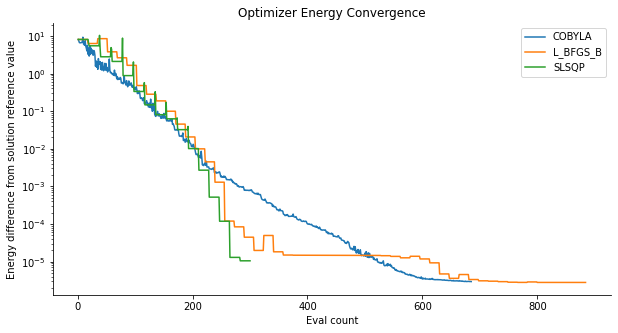

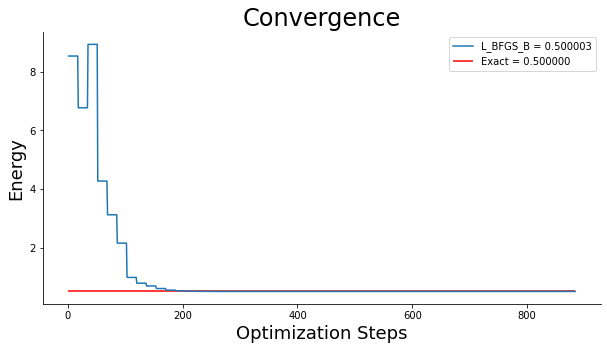

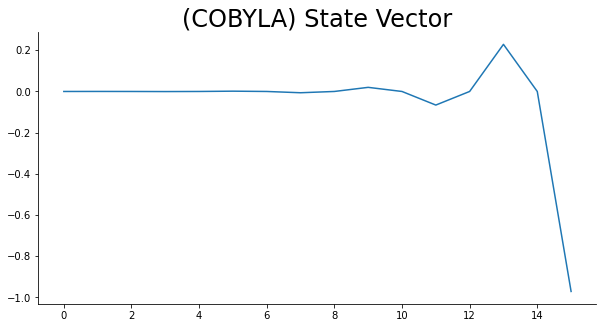

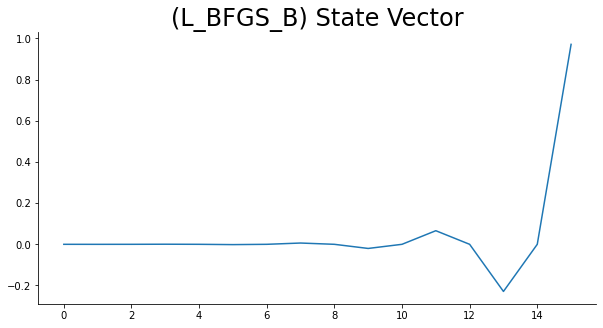

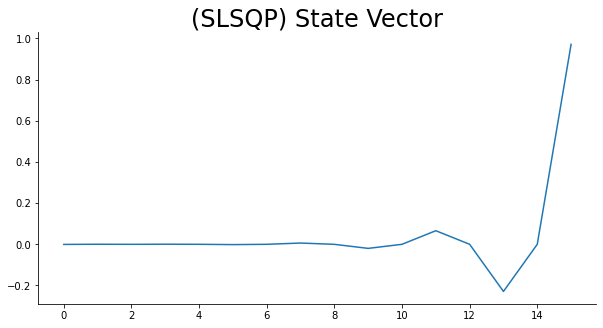

In [26]:
visualize_results(**harmonic_osc)
plt_state_vector(**harmonic_osc)

# 1-D Anharmonic Oscillator
### Example taken from pg. 440 from red text book

The Anharmonic Oscillator has a potential of the form
$$V(x) = \lambda x^{4} $$
where $\lambda$ is a constant.

The first step in the variational method is to choose a trial wave function that we hope best represents the actual wave function. Unfortunately this boils down to a complete guess, but we can still get very acurate results with some reasoning. We expect the following with regards to the ground state:
1. It will have parity
2. It will have no nodes
3. It will have even parity
4. It will peak at $x = 0$ so as to minimize $V(x)$
5. It will vanish as $|x| \rightarrow \infty$

A trial wave fucntion that has all of these properties with the added nicety of being easy to integrate and differentiate is a Gaussian of the form:

$$\psi(x, \alpha) = e^{-\alpha x^{2}/2}$$
where $\alpha$ is a free parameter

Therefore, the energy function $E(\alpha)$ as a function of $\alpha$ is:

$$E(\alpha) = \frac{\int e^{-\alpha x^{2}/2} (-\frac{\hbar^{2}}{2m}\frac{d^{2}}{dx^{2}} + \lambda x^{4}) e^{-\alpha x^{2}/2}dx}{\int e^{-\alpha x^{2}/2} dx} = \frac{\hbar^{2}\alpha}{4m} + \frac{3\lambda}{4\alpha^{2}}$$

Our goal is to find $E_{gs}$, which means we need to find the minimum of $E(\alpha)$. To do this we simply differentiate $E(\alpha)$, set it equal to $0$, and solve for $\alpha$

$$\frac{dE}{d\alpha} = \frac{\hbar^{2}}{4m} - \frac{3\lambda}{2\alpha^{3}} = 0 \implies \alpha_{0} = \left(\frac{6m\lambda}{\hbar^{2}}\right)^{1/3}$$

$\alpha_{0}$ corresponds to the minimum of the energy function, which is:
$$E(\alpha_{0}) = \frac{3}{8} \left(\frac{6\hbar^{4}\lambda}{m^{2}}\right)^{1/3}$$

We know for a fact that the ground state energy of the anharmonic oscillator is roughly $1.06$ eV. Using units such that $\hbar = 1$ & $\lambda = 1$, along with $m = \frac{1}{2}$ and plug them into $E(\alpha_{0})$, we get the following:

In [19]:
anh_gs = (3/8) * (6 / (1/2)**2) ** (1/3)
print(f'Upper bound for the ground state energy of the anharmonic oscillator: {anh_gs:.2f} eV')
print(f'Percent error: {abs((anh_gs-1.06)/1.06)*100:.2f}%')

Upper bound for the ground state energy of the anharmonic oscillator: 1.08 eV
Percent error: 2.05%


The Variational method got us an upper bound that was roughly 2% away from the actual ground state energy. While this isn't exactly the ground state, for most applications 2% is well close enough to be able to use the value constructively .

# Anharmonic Oscillator VQE

In [24]:
anh_osc_params = {
    'file_path': r'JA_adapted_anharmonic_oscillator_q=4.txt',
    'init_state_name': Zero,
    'vf_name': RY,
    'depth': 5,
    'shots': 5000,
    'simulator': 'statevector_simulator'
}

anharmonic_osc = run_VQE(**anh_osc_params)
print_table(**anharmonic_osc)

55 Pauli factors 
0 s to process
Optimization complete        

Hamiltonian: JA_adapted_anharmonic_oscillator_q=4
Reference Value: 1.0630119698756249
╒═════════════╤══════════════╤═══════════╕
│ Optimizer   │   VQE Energy │   % Error │
╞═════════════╪══════════════╪═══════════╡
│ SLSQP       │      1.06824 │  0.492202 │
├─────────────┼──────────────┼───────────┤
│ L_BFGS_B    │      1.06825 │  0.493147 │
├─────────────┼──────────────┼───────────┤
│ COBYLA      │      3.72742 │   250.647 │
╘═════════════╧══════════════╧═══════════╛


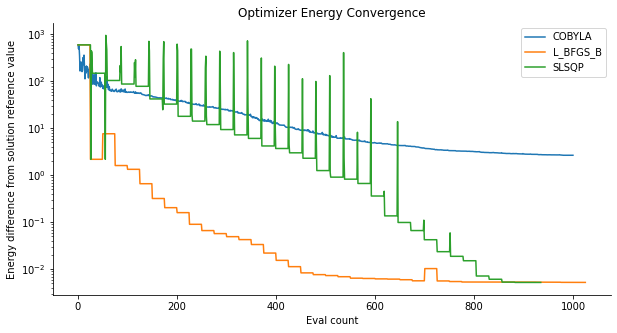

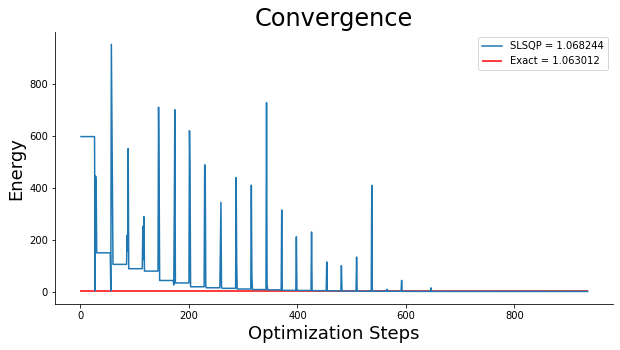

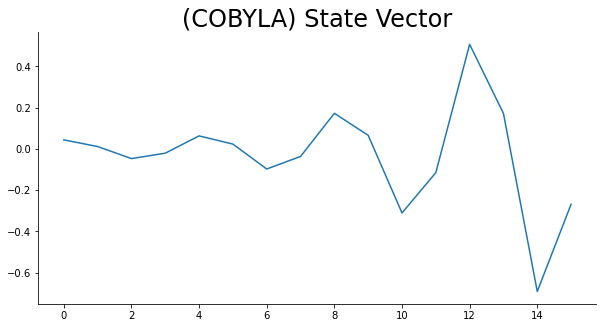

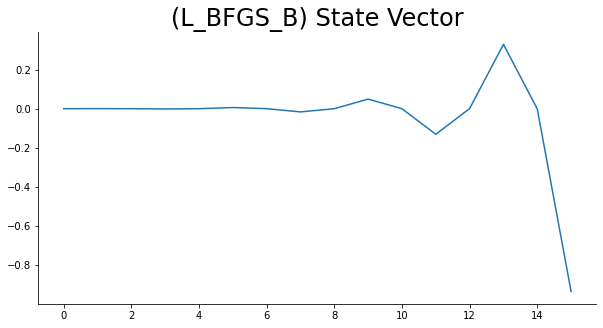

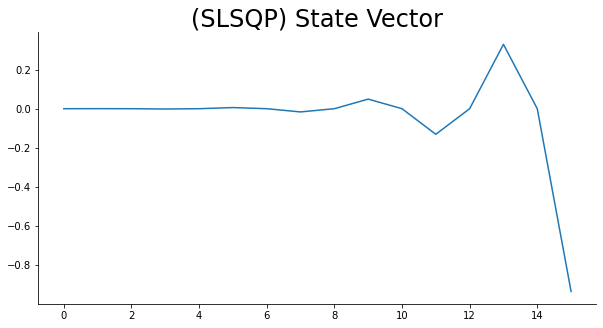

In [25]:
visualize_results(**anharmonic_osc)
plt_state_vector(**anharmonic_osc)

In [7]:
%qiskit_copyright

# References

- [Quantum Computing: An Applied Approach](https://github.com/JackHidary/quantumcomputingbook)
- [Variational Quantum Eigensolver explained](https://www.mustythoughts.com/post/variational-quantum-eigensolver-explained)
- [VQE Notebook](https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb)
- [Simulating Molecules using VQE](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Simulating-Molecules-using-VQE)
- [Quantum chemistry as a benchmark for near-term quantum computers](https://www.nature.com/articles/s41534-019-0209-0)
- [Generalization of the output of variational quantum eigensolver by parameter interpolation with low-depth ansatz](https://arxiv.org/abs/1810.04482)
- [Digital quantum simulation of molecular vibrations](https://pubs.rsc.org/en/content/articlelanding/2019/sc/c9sc01313j#!divAbstract)
- [Variational Forms (qiskit guide)](https://qiskit-staging.mybluemix.net/documentation/aqua/variational_forms.html)
- [Quantum computing a Gaussian wavefunction](https://medium.com/@sohaib.alam/quantum-computing-a-gaussian-wavefunction-2d0be23d77b2)
- [Variational-Quantum-Eigensolver (VQE) (grove docs)](https://grove-docs.readthedocs.io/en/latest/vqe.html)